In [1]:
import numpy as np
from astropy.io import fits

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
import seaborn as sns

import wf_psf as wf




In [2]:
# Paths
input_path = './../../../data/SEDs/Pickles_input/'
savefig_path = './../figures/'
save_SED_path = './../../../data/SEDs/save_SEDs/'



In [3]:
def define_plot_style():
    # Define plot paramters
    # Use seaborn style
    sns.set(font_scale=1.5)
    
    plot_style = {
        'figure.figsize': (12,8),
        'figure.dpi': 200,
        'figure.autolayout':True,
        'lines.linewidth': 2,
        'lines.linestyle': '-',
        'lines.marker': '',
        'lines.markersize': 10,
        'legend.fontsize': 20,
        'legend.loc': 'best',
        'axes.titlesize': 24,
        'font.size': 22
    }
    mpl.rcParams.update(plot_style)


In [4]:
define_plot_style()


# Load Pickles SED

In [5]:
# Load SEDs

SED_prefix = ['o5', 'b0', 'b57', 'a0', 'a5', 'f0', 'f5', 'g0', 'g5', 'k0', 'k5', 'm0', 'm5']
SED_name = ['O5V', 'B0V', 'B5-7V', 'A0V', 'A5V', 'F0V', 'F5V', 'G0V', 'G5V', 'K0V', 'K5V', 'M0V', 'M5V']

cat_lbdas = []
cat_seds = []

for sed in SED_prefix:
    sed_file = fits.open(input_path + 'J_PASP_110_863_%sv.dat.gz.fits'%(sed))
    lbda = sed_file[1].data['lambda']
    # Define lbda mask
    lbda_mask = (lbda > 3000) * (lbda < 15500)
    # Load masked lbda
    cat_lbdas += [lbda[lbda_mask]]
    #Load masked SED
    cat_seds += [sed_file[1].data['nflam'][lbda_mask]]
    
cat_lbdas = np.array(cat_lbdas)
cat_seds = np.array(cat_seds)



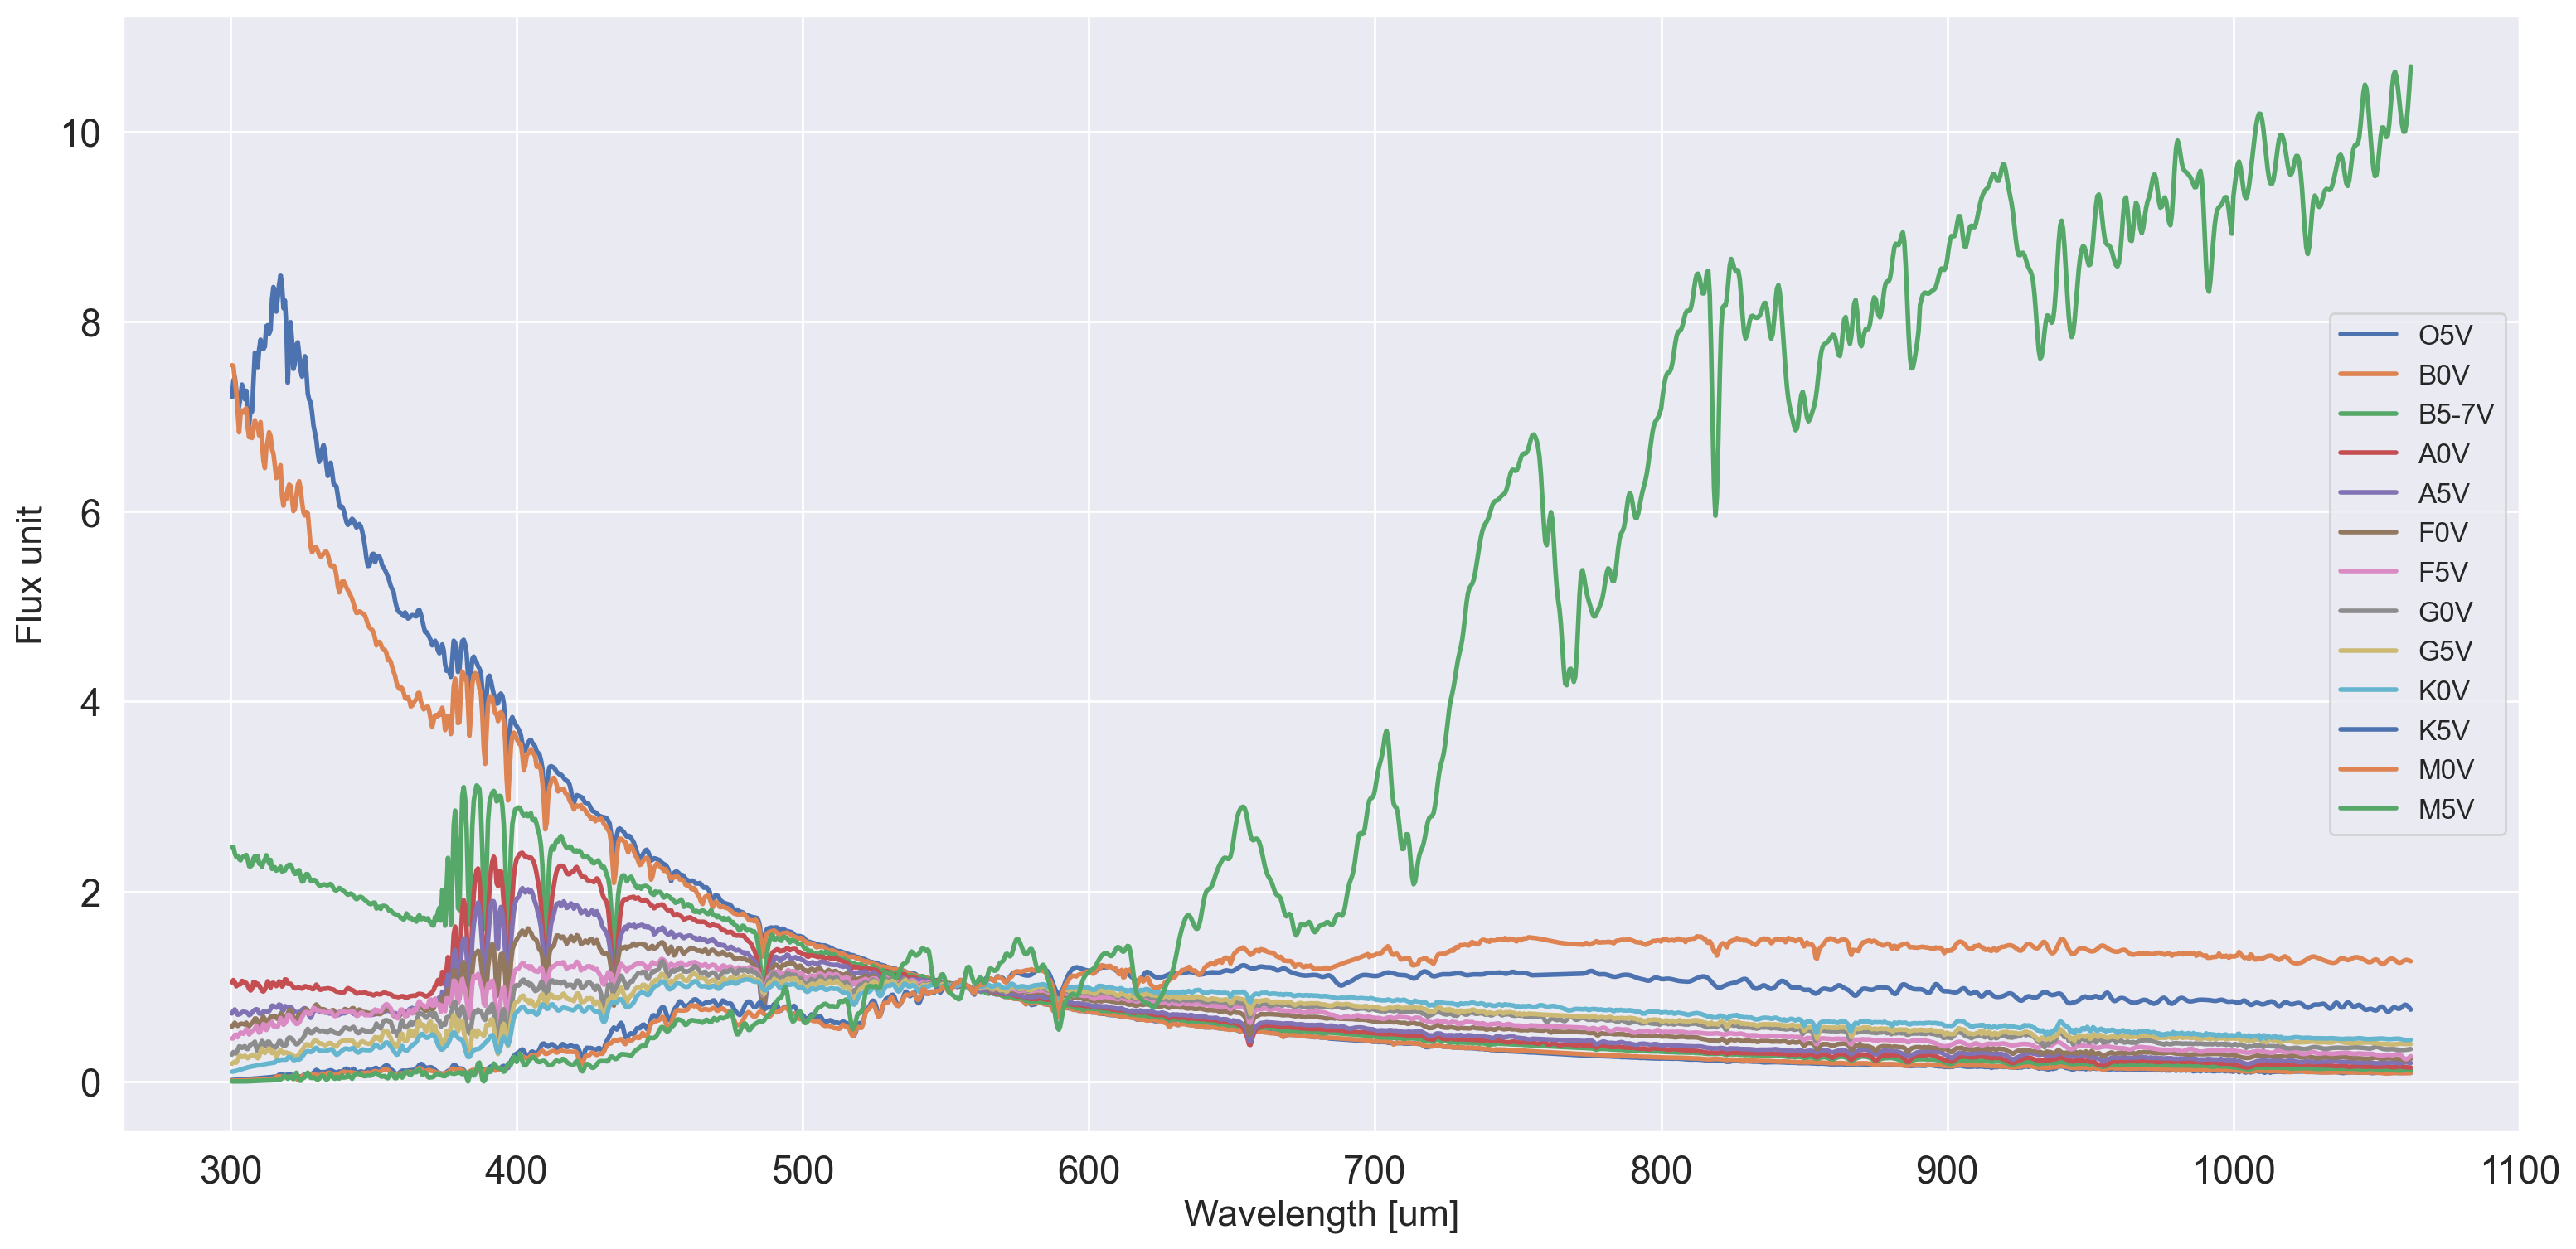

In [6]:
# Plot 
plt.figure(figsize=(16,8))

for lbda, sed, name in zip(cat_lbdas, cat_seds, SED_name):
    plt.plot(lbda/10, sed, label=name)

plt.legend(fontsize=12)
plt.xlabel('Wavelength [um]', fontsize=16)
plt.ylabel('Flux unit', fontsize=16)
plt.show()


# Prepare SEDs

In [7]:
# Mask into desired passband and normalize
lbda_step = 5  # Armstrong 

# Define passband in A
passband = [5500, 9000]

# lbda cats are shared and equally spaced by 5A
generic_lbda_cat = cat_lbdas[0]
# Build mask
mask_lbda = (generic_lbda_cat >= passband[0]) * (generic_lbda_cat < passband[1])

# Mask elements
passband_lbdas = cat_lbdas[:, mask_lbda]
passband_seds = cat_seds[:, mask_lbda]

# Normalize
passband_seds /= np.sum(passband_seds, axis=1).reshape(-1, 1)


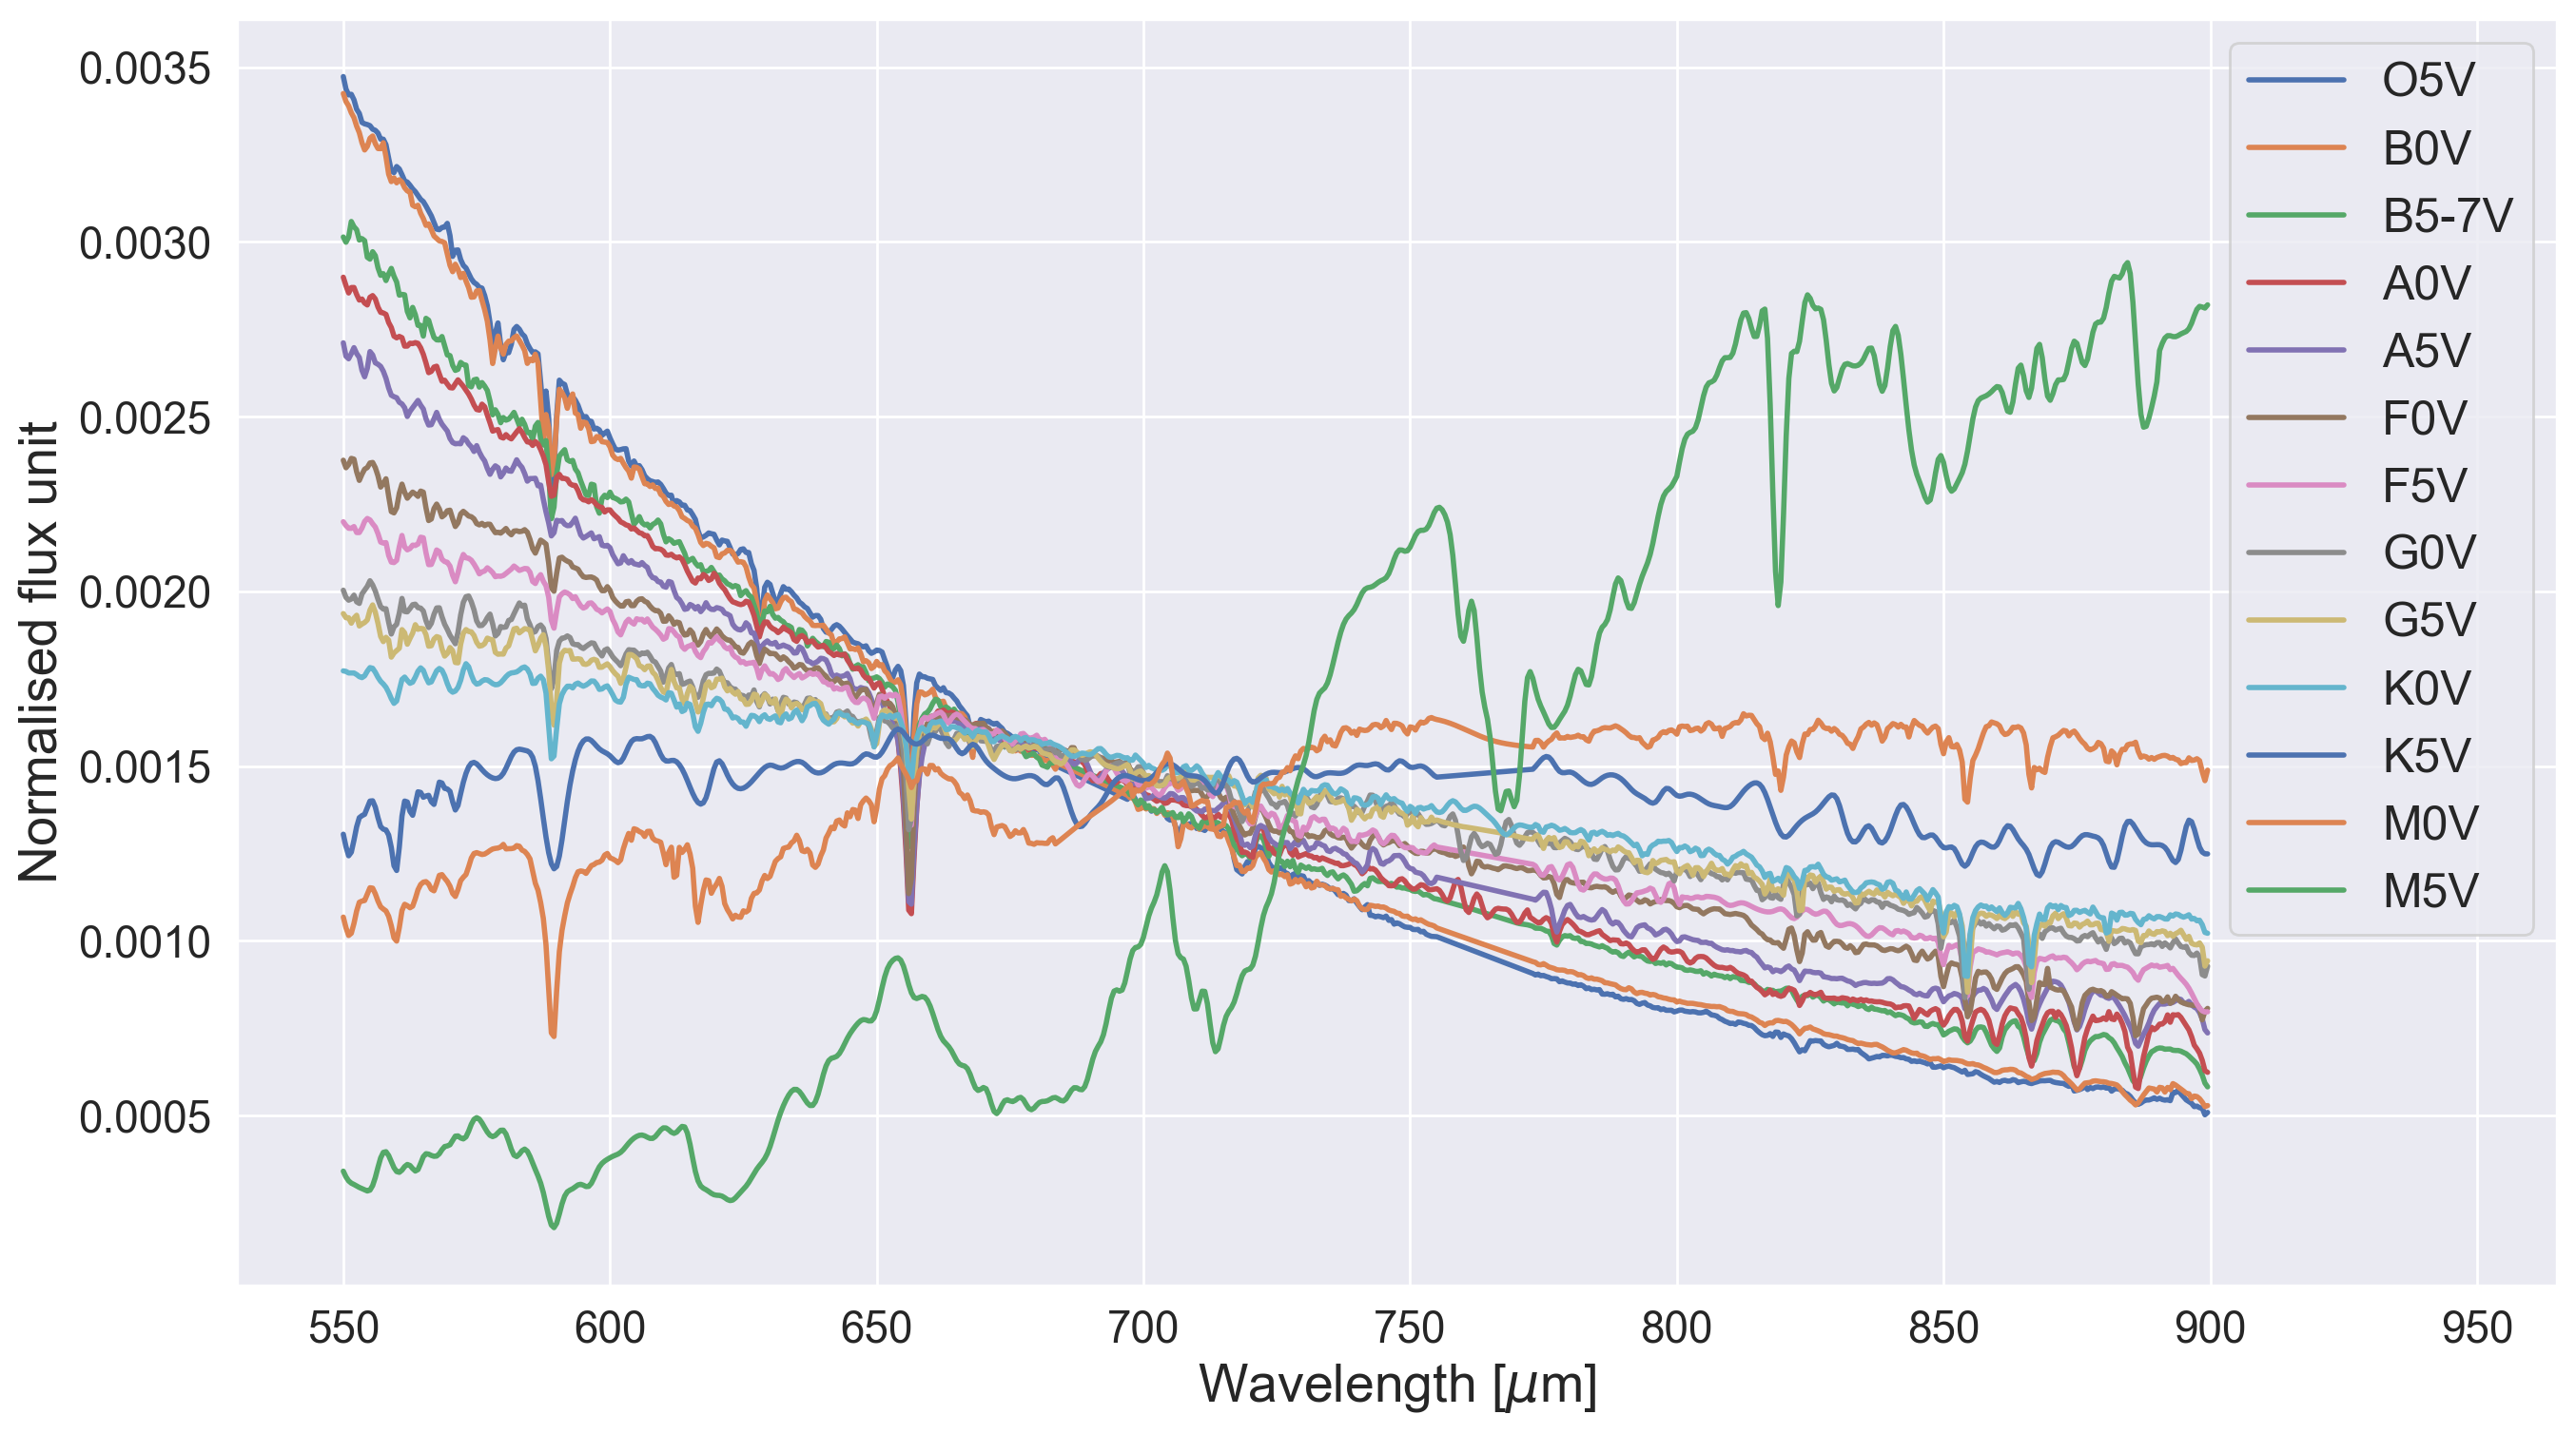

In [8]:
# Plot 
plt.figure(figsize=(14,8))

for lbda, sed, name in zip(passband_lbdas, passband_seds, SED_name):
    plt.plot(lbda / 10, sed, label=name)

ax = plt.gca()
plt.legend(fontsize=18)
plt.xlabel(r'Wavelength [$\mu$m]', fontsize=20)
plt.ylabel('Normalised flux unit', fontsize=20)
ax.set_xlim([530, 965])
plt.show()


## Bin into desired resolution

In [9]:

n_lbdas = 350
lbda_bins = np.linspace(5500, 9000, n_lbdas+1)

binned_seds = np.zeros((passband_seds.shape[0], n_lbdas))

for it in range(passband_seds.shape[0]):
    # Bin
    sed_bin, lbda_bin_edges = np.histogram(
        passband_lbdas[it,:],
        bins=lbda_bins,
        range=[5500., 9000.],
        weights=passband_seds[it,:],
        density=False
    )
    # Save
    binned_seds[it,:] = sed_bin


# Going from [A] to [um]
# Shifting from bin edges to bin center
binned_lbda = lbda_bin_edges[:-1]/10 + 0.5

# Normalize SEDs
binned_seds /= np.sum(binned_seds, axis=1).reshape(-1, 1)


In [10]:
# Save SEDs

np.save(save_SED_path + 'SEDs.npy', binned_seds, allow_pickle=True)
np.save(save_SED_path + 'lambdas.npy', binned_lbda, allow_pickle=True)



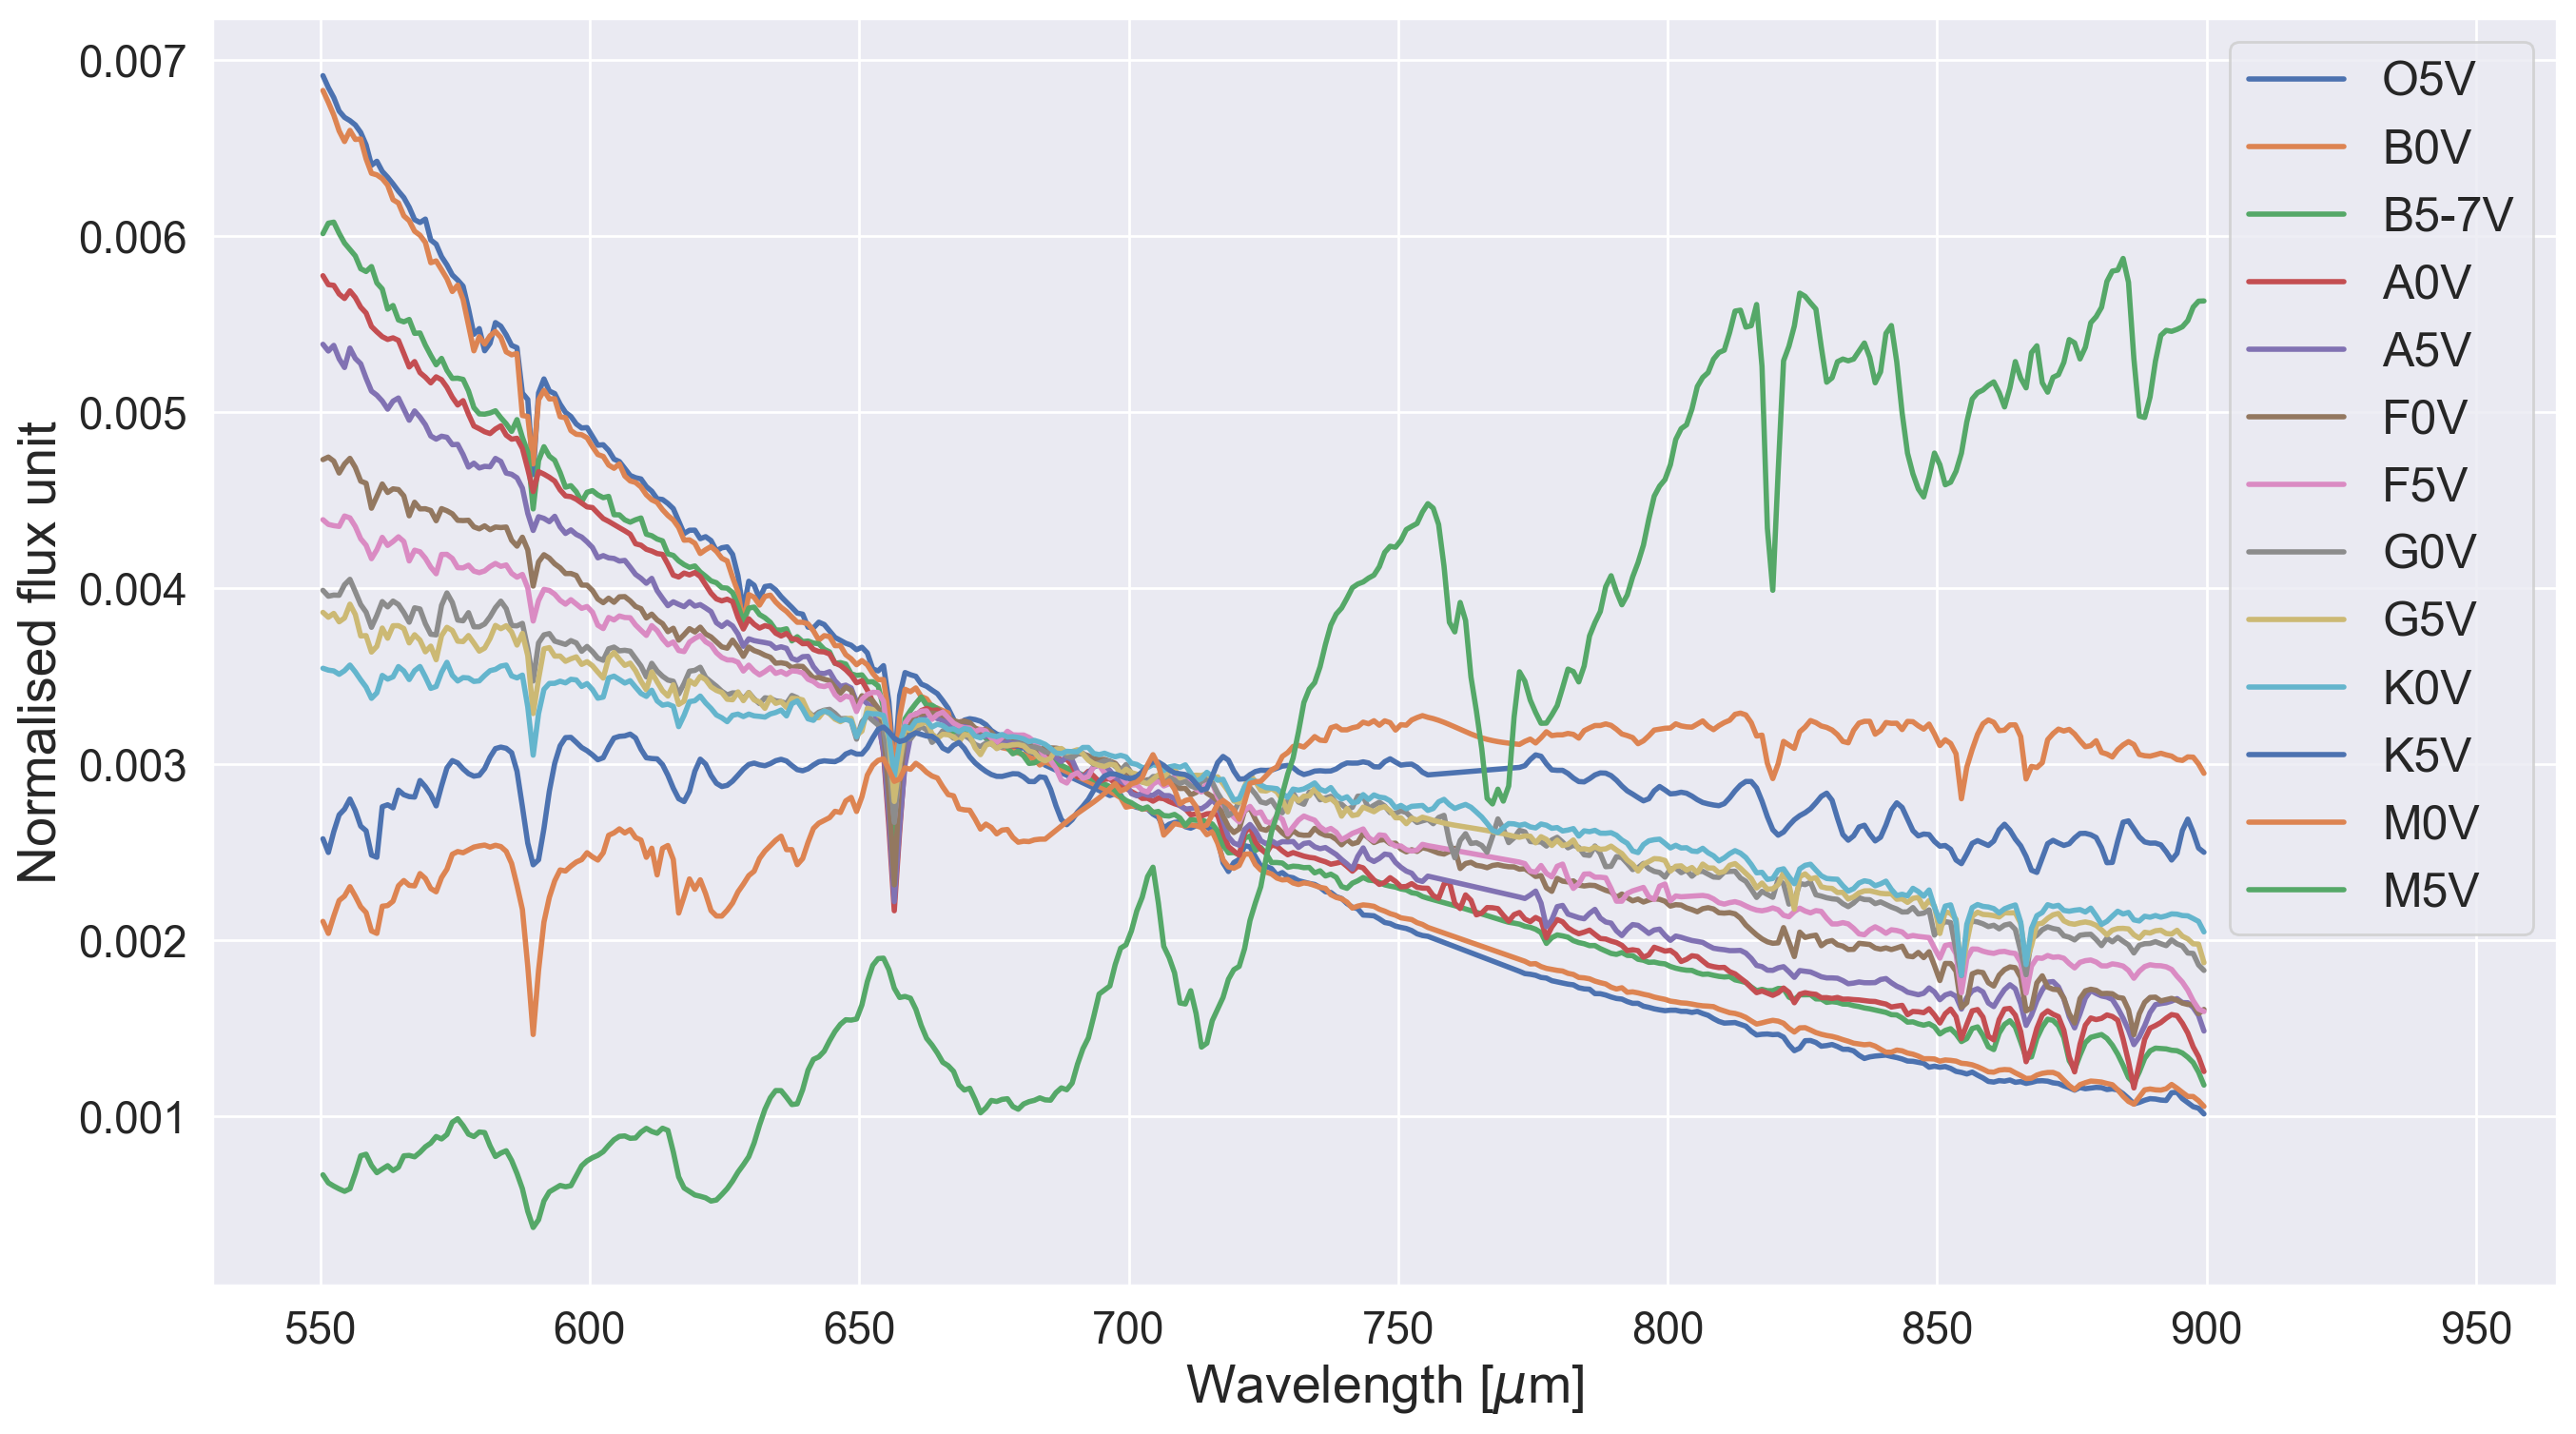

In [11]:

# Plot 
plt.figure(figsize=(14,8))

for sed, name in zip(binned_seds, SED_name):
    plt.plot(binned_lbda, sed, label=name)

ax = plt.gca()
plt.legend(fontsize=18)
plt.xlabel(r'Wavelength [$\mu$m]', fontsize=20)
plt.ylabel('Normalised flux unit', fontsize=20)
ax.set_xlim([530, 965])
plt.savefig(savefig_path + 'SEDs_plot.pdf')
plt.show()


